<a href="https://colab.research.google.com/github/prakhartiwari10/CV-Projects/blob/main/Wall_smoothness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="9hMZDsNXQWhkb3QxAPBb")
project = rf.workspace("texture-painting-robot-n8k3u").project("fyp-robot")
version = project.version(3)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


In [44]:
import pandas as pd
import os

labeled_data = pd.read_csv("labeled.csv")
test_labeled_data = pd.read_csv("test_labeled.csv")
val_labeled_data = pd.read_csv("val_labeled.csv")
print(labeled_data.head())
print(test_labeled_data.head())
print(val_labeled_data.head())

                                          image_path  smoothness_score
0  /content/fyp-robot-3/train/images/20240122_101...                70
1  /content/fyp-robot-3/train/images/20240122_101...                70
2  /content/fyp-robot-3/train/images/20240122_101...                65
3  /content/fyp-robot-3/train/images/20240122_101...                88
4  /content/fyp-robot-3/train/images/20240122_101...                90
                                          image_path  smoothness_score
0  /content/fyp-robot-3/test/images/20240122_1019...                64
1  /content/fyp-robot-3/test/images/20240122_1019...                72
2  /content/fyp-robot-3/test/images/20240122_1019...                76
3  /content/fyp-robot-3/test/images/20240122_1020...                86
4  /content/fyp-robot-3/test/images/20240122_1020...                93
                                          image_path  smoothness_score
0  /content/fyp-robot-3/valid/images/20240122_101...                70
1  /co

In [45]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image
import os

In [46]:
class WallDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        image = Image.open(img_path).convert("RGB")
        label = self.data.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)


In [47]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [48]:
resnet = models.resnet50(pretrained=True)
resnet.eval()

feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
feature_extractor.eval()

for param in feature_extractor.parameters():
    param.requires_grad = False

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


In [50]:
def extract_features(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    features = []
    labels = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            outputs = outputs.view(outputs.size(0), -1)

            features.append(outputs)
            labels.append(targets.view(-1))

    return torch.cat(features), torch.cat(labels)


In [51]:
train_csv = 'labeled.csv'
val_csv = 'val_labeled.csv'

train_dataset = WallDataset(csv_file=train_csv, transform=transform)
val_dataset = WallDataset(csv_file=val_csv, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_features, train_labels = extract_features(train_loader, feature_extractor)
val_features, val_labels = extract_features(val_loader, feature_extractor)

train_features, train_labels = train_features.to(device), train_labels.to(device)
val_features, val_labels = val_features.to(device), val_labels.to(device)

In [53]:
class RegressionHead(nn.Module):
    def __init__(self, input_dim):
        super(RegressionHead, self).__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.fc(x)

regression_model = RegressionHead(input_dim=train_features.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(regression_model.parameters(), lr=1e-3)


In [81]:
num_epochs = 500

for epoch in range(num_epochs):

    regression_model.train()
    optimizer.zero_grad()

    predictions = regression_model(train_features).squeeze()
    train_loss = criterion(predictions, train_labels)
    train_loss.backward()
    optimizer.step()

    regression_model.eval()
    with torch.no_grad():
        val_predictions = regression_model(val_features).squeeze()
        val_loss = criterion(val_predictions, val_labels)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch 1, Train Loss: 45.3899, Val Loss: 501.5823
Epoch 2, Train Loss: 45.3715, Val Loss: 501.5609
Epoch 3, Train Loss: 45.3531, Val Loss: 501.5392
Epoch 4, Train Loss: 45.3348, Val Loss: 501.5175
Epoch 5, Train Loss: 45.3164, Val Loss: 501.4963
Epoch 6, Train Loss: 45.2980, Val Loss: 501.4748
Epoch 7, Train Loss: 45.2797, Val Loss: 501.4536
Epoch 8, Train Loss: 45.2613, Val Loss: 501.4324
Epoch 9, Train Loss: 45.2430, Val Loss: 501.4111
Epoch 10, Train Loss: 45.2246, Val Loss: 501.3901
Epoch 11, Train Loss: 45.2062, Val Loss: 501.3691
Epoch 12, Train Loss: 45.1879, Val Loss: 501.3482
Epoch 13, Train Loss: 45.1696, Val Loss: 501.3273
Epoch 14, Train Loss: 45.1512, Val Loss: 501.3066
Epoch 15, Train Loss: 45.1329, Val Loss: 501.2860
Epoch 16, Train Loss: 45.1146, Val Loss: 501.2652
Epoch 17, Train Loss: 45.0963, Val Loss: 501.2447
Epoch 18, Train Loss: 45.0780, Val Loss: 501.2244
Epoch 19, Train Loss: 45.0597, Val Loss: 501.2039
Epoch 20, Train Loss: 45.0414, Val Loss: 501.1836
Epoch 21,

In [82]:
test_csv = 'test_labeled.csv'

test_dataset = WallDataset(csv_file=test_csv, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

test_features, test_labels = extract_features(test_loader, feature_extractor)
test_features, test_labels = test_features.to(device), test_labels.to(device)

with torch.no_grad():
    test_predictions = regression_model(test_features).squeeze()
    test_loss = criterion(test_predictions, test_labels)

print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 1018.1395


In [103]:
test_features, test_labels = extract_features(test_loader, feature_extractor)
test_features = test_features.to(device)
test_preds = test_labels.cpu().numpy()

regression_model.eval()
with torch.no_grad():
    predicted_scores = regression_model(test_features).squeeze().cpu().numpy()

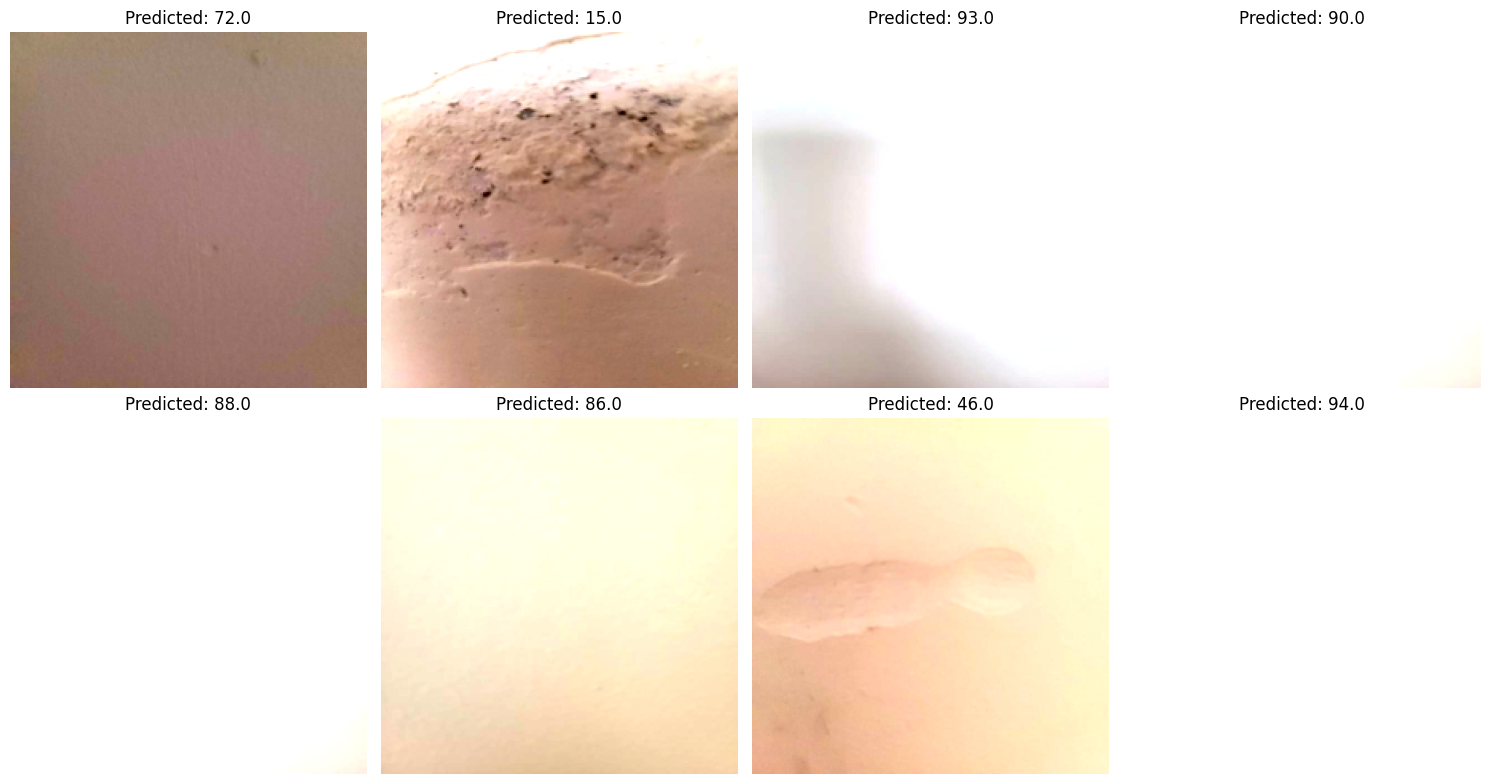

In [104]:
import matplotlib.pyplot as plt
import numpy as np

test_images, _ = next(iter(test_loader))
test_images = test_images.cpu().numpy()

def unnormalize(img):
    img = img.transpose(1, 2, 0)
    img = img * 0.5 + 0.5
    img = np.clip(img, 0, 1)
    return img

num_samples = 8
indices = np.random.choice(len(test_images), num_samples, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for i, idx in enumerate(indices):
    ax = axes[i // 4, i % 4]
    img = unnormalize(test_images[idx])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Predicted: {test_preds[idx]:.1f}")

plt.tight_layout()
plt.show()